In [1]:
!pip install matplotlib
!pip install qutip
!pip install numpy 
!pip install scipy
!pip install Cython  

In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_bosonic_proj_ev as me

from IPython.display import display, Math, Latex

In [14]:
def two_body_gaussian_state(L, dim, coeffs, visualization = False):
    loc_globalid_list,loc_destroy_list,loc_create_list,loc_num_list = me.basic_bos_ops(L, dim)
    
    a = len(me.basic_bos_ops(L, dim))
    b = len(me.basic_bos_ops(L, dim)[0])
    coeffs_list = coeffs * np.full((a,b),1)
    
    K = 0;
    
    K += sum(coeffs_list[a][b] * me.basic_bos_ops(L, dim)[a][b] 
             for a in range(L) for b in range(L))
    
    rho_loc = 0
    rho_loc = K.expm()
    rho_loc = rho_loc/ rho_loc.tr()
    
    if me.is_density_op(rho_loc):
        pass 
    else:  
        rho_loc = None 
        raise Exception("The result is not a density operator")
        
    if visualization: 
        qutip.hinton(rho_loc)
    
    return rho_loc

In [15]:
two_body_gaussian_state(3, 5, 10**-6, False)

Quantum object: dims = [[5, 5, 5], [5, 5, 5]], shape = (125, 125), type = oper, isherm = True
Qobj data =
[[8.00000000e-03 8.00000000e-09 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.00000000e-09 8.00000000e-03 1.13137085e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.13137085e-08 8.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.00000000e-03
  1.38564065e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.38564065e-08
  8.00000000e-03 1.60000000e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.60000000e-08 8.00000000e-03]]

In [14]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.max_ent_app = None
        self.projrho0_app = None
        self.projrho_inst_app = None 

def simul(omega_bos=3, omega_s=3, temp=1, gaussian=False, deltat=10., tmax=500., distance=bures):
    basis_bos = [qutip.qeye(dim), qutip.create(dim),qutip.create(dim).dag(),qutip.num(dim)]
    H_bos = qutip.tensor(qutip.num(dim), qutip.qeye(2))
    H_i = qutip.tensor(.5*(qutip.create(dim)+qutip.destroy(dim)), qutip.sigmax())
    # Estado inicial
    rho0 = qutip.tensor((-qutip.num(dim)/temp).expm(), qutip.qeye(2)/2.)
    rho0 = rho0/rho0.tr()
    # Base
    if gaussian:
        basis_spin = [qutip.qeye(2), qutip.sigmax()]
        H_s = qutip.tensor(qutip.qeye(dim),qutip.sigmax())
    else:
        basis_spin = [qutip.qeye(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]
        H_s = qutip.tensor(qutip.qeye(dim),qutip.sigmaz())
        
    basis = base_orto(prod_basis(basis_bos, basis_spin), rho0)
    # Hamiltoniano
    H = omega_bos * H_bos + omega_s * H_s + H_i

    sampling = int(10*max(1,omega_bos, omega_s)*deltat)
    
    states = [rho0]
    rho = rho0    
    ts= [0]
    for i in range(int(tmax/deltat)):
        result = qutip.mesolve(H, states[-1], np.linspace(0,deltat, sampling))
        states.append(result.states[-1])
        ts.append(deltat*i)
    
    result = Result(ts, states)
    result.times = ts
    result.states = states
    result.max_ent_app = np.array([error_maxent_state(rho, basis, distance) for rho in states])
    result.projrho0_app = np.array([error_proj_state(rho, rho0, basis,distance) for rho in states])
    result.projrho_inst_app = np.array([error_proj_state(rho, qutip.tensor(rho.ptrace([0]),rho.ptrace([1])), 
                                                         basis, distance) for rho in states])
    
    if gaussian:
        title = distance.__name__ + f" - DinÃ¡mica gaussiana    dim={dim} wb={omega_bos} dw={abs(omega_s-omega_bos)} "
    else:
        title = distance.__name__ + f" - DinÃ¡mica no gaussiana dim={dim} wb={omega_bos} dw={abs(omega_s-omega_bos)} " 

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result, title

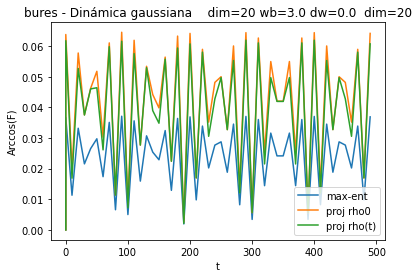

In [15]:
## DinÃ¡mica Gaussiana, resonante


result, title = simul(omega_bos=3., omega_s=3., temp=1, 
                      gaussian=True, 
                      deltat=10., tmax=500., 
                      distance=bures)

plt.plot(result.times, result.max_ent_app, label="max-ent")
plt.plot(result.times, result.projrho0_app, label="proj rho0")
plt.plot(result.times, result.projrho_inst_app, label="proj rho(t)")
plt.xlabel("t")
plt.ylabel("Arccos(F)")

plt.legend()
plt.title(title + f" dim={dim}")
plt.savefig(title + f" dim={dim}.svg")